**Source Code : 1 Pengolahan Data dari Bentuk APC ke ATEPC**

### *Load Folder and Dataset*
---

In [1]:
%cd /home/bimad4/data/data_apc_atepc/

/home/bimad4/data/data_apc_atepc


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/bimad4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### *Merging Data APC menjadi 1 File*

---

In [3]:
import string
import re
import os.path
from os import path
from nltk.tokenize import sent_tokenize

In [4]:
all_data_lines = []
i=0
while i< 20:
  file=open("apc_dataset_"+str(i)+".txt", "r")
  text = file.readlines()
  text[len(text)-1] =  text[len(text)-1] + "\n"
  all_data_lines = all_data_lines + text
  i=i+1

new_file = open("apc_merge_dataset.txt", "w")
new_file.writelines(all_data_lines)
new_file.close()

### *Pre-processing Data (Feature Extraction)*

---

In [5]:
def clean_sentences(sentences):
  for sentence in sentences:
    if "$T$" in sentence:
      return sentence

In [6]:
def split_sentence(article):
  tokens = nltk.tokenize.sent_tokenize(article)
  return tokens

In [7]:
a_file = open("apc_merge_dataset.txt", "r")
articles = a_file.readlines()

i =0

while i < (len(articles)):
  ### hapus url
  articles[i] = re.sub('\S+.com|\S+.co.id|\S+.co|\S+.id', '.', articles[i])
  
  ### hapus titik yang bukan pemisah kalimat 
  articles[i] = articles[i].replace("PT.", "PT").replace("Tbk.", "Tbk")
  for number in range(100):
    articles[i] = articles[i].replace(" "+str(number)+". ", " " )

  ### Split dan ambil kalimat yang mengandung emiten
  list_of_sentences = split_sentence(articles[i])
  new_sentence = clean_sentences(list_of_sentences)

  ### Hapus tanda baca kecuali '$' 
  new_sentence = re.sub(r'[^\w\d\s\$\.]+', '', str(new_sentence))

  ### Menambahkan karakter unik sebagai pemisah antar artikel
  articles[i] = new_sentence + " EOF \n"
    
  i = i+3
a_file.close()

In [8]:
### save file after preprocessing
new_file = open("dataset_apc_final.txt", "w")
new_file.writelines(articles)
new_file.close()

### Convertion Data from APC to ATEPC

---



In [9]:
!pip install pyabsa==1.16.27


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [10]:
from pyabsa.utils.file_utils import convert_apc_set_to_atepc_set
from pyabsa.functional import ABSADatasetList

2023-06-11 16:57:17.859302: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/bimad4/anaconda3/envs/absa-env/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/bimad4/anaconda3/envs/absa-env/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/bimad4/anaconda3/envs/absa-env/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/bimad4/anaconda3/envs/absa-env/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: 

Version 0.8.7.4 of metric_visualizer is outdated. Version 0.9.7 was released Wednesday April 12, 2023.
Version 1.16.27 of pyabsa is outdated. Version 2.3.1 was released Saturday April 15, 2023.
PyABSA INFO: The PyABSA >= 2.0.0 version contains breaking changes, if you want to use the training and inference scripts (in demos directory), please do not upgrade to the >= 2.0.0 version
check release notes at https://github.com/yangheng95/PyABSA/blob/release/release-note.json


In [11]:
convert_apc_set_to_atepc_set('dataset_apc_final.txt') 

To ensure your conversion is successful, make sure the dataset name contain "apc" and "dataset" string 
Find datasets files at dataset_apc_final.txt:
coverting dataset_apc_final.txt to dataset_apc_final.txt.atepc
finished


In [12]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### Convertion Data from ATEPC to APC
---



In [13]:
!cp dataset_apc_final.txt.atepc atepc_final_data.txt

In [14]:
import pandas as pd
import csv

In [15]:
def to_csv(path, name):
    df = pd.read_csv(path, sep='\t', names=['text'], quoting=csv.QUOTE_NONE)
    print(len(df))
    df = pd.DataFrame(df.text.str.split(' ',).tolist(), columns=['token', 'tag', 'pol'])
    print(len(df))
    df.head(10)

    tokens_list=[]
    tags_list=[]
    pols_list=[]

    tokens=[]
    tags=[]
    pols=[]

    for i in range(len(df)):
        
        token, tag, pol = df.iloc[i, :3].values

        tokens.append(token)

        if tag == 'O' : 
            tags.append(0)
        elif tag == 'B-ASP':
            tags.append(1)
        else: 
            tags.append(1)
  
        if pol == "Positive":
          final_pol = 2
        elif pol == "Neutral":
          final_pol = 1
        elif pol == "Negative":
          final_pol = 0
        else:
          final_pol =  -1
        
        pols.append(int(final_pol))

        if token == "EOF":
            tokens.pop()
            tags.pop()
            pols.pop()
           
            ### to lower case
            for k in range(len(tokens)):
              tokens[k] = tokens[k].lower()

            if(len(tokens) > 1):
              tokens_list.append(tokens)
              tags_list.append(tags)
              pols_list.append(pols)
            
            tokens=[]
            tags=[]
            pols=[]

    data = {'Tokens':tokens_list, 
            'Tags': tags_list, 
            'Polarities': pols_list}

    df = pd.DataFrame(data)
    print(len(df))
    df.head()

    df.to_csv(name, index=False)  

In [16]:
#pastiin sesuai sama nama file atepc nya
to_csv('atepc_final_data.txt','final_data.csv')

1110488
1110488
24654


In [17]:
# remove duplicate
# gabisa dibikin di fungsi to_csv malah error unhashable list

file_name = "final_data.csv"
df = pd.read_csv(file_name)

df = df.drop_duplicates( subset = ['Tokens', 'Tags', 'Polarities'])
print(len(df))

file_name_output = "final_data.csv"
# Write the results to a different file
df.to_csv(file_name_output, index=False)

21760


### Total Data Visualization
---

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [19]:
def bar_chart(training_data_path):
  df = pd.read_csv(training_data_path)
  df = df.Polarities.apply(lambda x: x.strip('][').split(', '))

  neg = 0
  net = 0
  pos = 0
  for i in range(len(df)):
    if('0' in df[i]):
      neg = neg + 1
    elif('1' in df[i]):
      net = net + 1
    elif('2' in df[i]):
      pos = pos + 1

  # creating the dataset
  data = {'Negative':neg, 'Neutral':net, 'Positive':pos}
  courses = list(data.keys())
  values = list(data.values())
    
  fig = plt.figure(figsize = (10, 5))
  
  # creating the bar plot
  plt.bar(courses, values, color =['red', 'blue', 'green'],
          width = 0.4)
  
  plt.xlabel("Sentiment")
  # plt.ylabel("No. of students enrolled")
  plt.title("Number of row")
  plt.show()

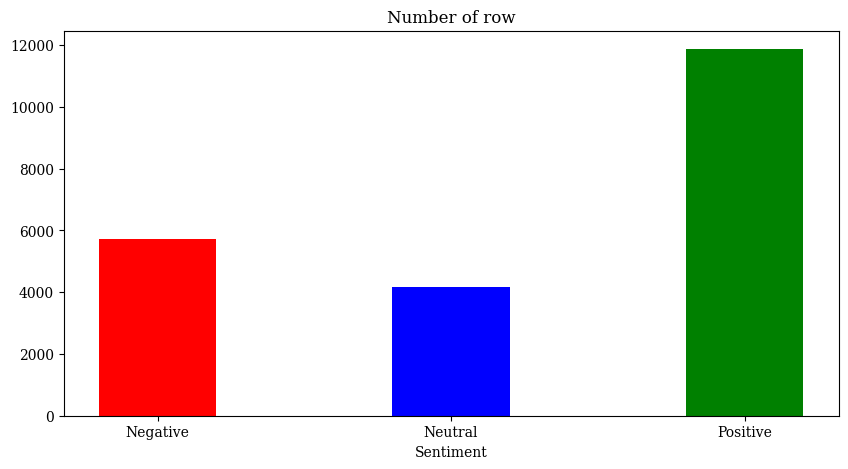

In [20]:
bar_chart("final_data.csv")

### Data Balancing
---

In [21]:
import pandas as pd
import numpy as np
import random

In [22]:
df = pd.read_csv("final_data.csv")

df_pos = pd.DataFrame(columns=['Tokens', 'Tags', 'Polarities'])
df_net = pd.DataFrame(columns=['Tokens', 'Tags', 'Polarities'])
df_neg = pd.DataFrame(columns=['Tokens', 'Tags', 'Polarities'])

polarities = df.Polarities.apply(lambda x: x.strip('][').split(', '))

for i in range(len(df)):
  if('0' in polarities[i]):
    df_neg = df_neg.append(df.loc[i])
  elif('1' in polarities[i]):
    df_net = df_net.append(df.loc[i])
  elif('2' in polarities[i]):
    df_pos = df_pos.append(df.loc[i])

In [23]:
df_pos = df_pos.sample(frac = 1).reset_index(drop=True)
df_net = df_net.sample(frac = 1).reset_index(drop=True)
df_neg = df_neg.sample(frac = 1).reset_index(drop=True)
df_net_balance = df_net
df_pos_balance = df_pos
df_neg_balance = df_neg

In [24]:
print(len(df_neg_balance), len(df_net_balance), len(df_pos_balance))

5712 4166 11876


Balancing Data

In [25]:
df_pos_balance['split'] = np.random.randn(df_pos_balance.shape[0], 1)
df_net_balance['split'] = np.random.randn(df_net_balance.shape[0], 1)
df_neg_balance['split'] = np.random.randn(df_neg_balance.shape[0], 1)

#### Balance normal ideal (minimal length kelas terkecil)
#df_pos_balance = df_pos_balance[0:(len(df_net_balance))]
#df_net_balance = df_net_balance[0:(len(df_net_balance))]
#df_neg_balance = df_neg_balance[0:(len(df_net_balance))]

#### Ambil data 100 buat testing data grid dan random.
df_pos_balance = df_pos_balance[0:len(df_net_balance)]
df_net_balance = df_net_balance[0:len(df_net_balance)]
df_neg_balance = df_neg_balance[0:len(df_net_balance)]

In [26]:
print(len(df_neg_balance), len(df_net_balance), len(df_pos_balance))

4166 4166 4166


Pembagian Training dan Test Data

In [27]:
    msk_pos = np.random.rand(len(df_pos_balance)) <= 0.8
    msk_net = np.random.rand(len(df_net_balance)) <= 0.8
    msk_neg = np.random.rand(len(df_neg_balance)) <= 0.8

In [28]:
train = df_pos_balance[msk_pos]
train = train.append(df_net_balance[msk_net])
train = train.append(df_neg_balance[msk_neg])

test = df_pos_balance[~msk_pos]
test = test.append(df_net_balance[~msk_net])
test = test.append(df_neg_balance[~msk_neg])

train.drop('split', inplace=True, axis=1)
test.drop('split', inplace=True, axis=1)

In [29]:
#jumlah data train
print(len(df_neg_balance[msk_neg]), len(df_net_balance[msk_net]), len(df_pos_balance[msk_net]))

3347 3325 3325


In [30]:
#jumlah data test
print(len(df_neg_balance[~msk_neg]), len(df_net_balance[~msk_net]), len(df_pos_balance[~msk_net]))

819 841 841


In [31]:
train.to_csv("data_balance_experiment_training.csv", index=False)
test.to_csv("data_balance_experiment_testing.csv", index=False)

In [32]:
len(train)

10003

In [33]:
len(test)

2495